# Lesson 37: Practice with pairs bootstrap and Bokeh *solution*

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This lesson was generated from a Jupyter notebook.  You can download the notebook [here](l37_practice_with_pairs_bs_and_bokeh_solution.ipynb).*

<br /><br />

In [1]:
import numpy as np
import scipy.special
import pandas as pd

import altair as alt
import bokeh.io

import bootcamp_utils

bokeh.io.output_notebook()

Loading BokehJS ...

## Practice 1: Heritability

The **heritability** of a trait in a sexually reproducing animal is defined as follows.
1. For a given pair of parent, take the mean value of the trait. Call this the parental trait.
2. Take the mean value of the trait of all of the offspring of the two parents. Call this the offspring trait.
3. Do this for all parental/offspring pairs.
4. The **heritability** is defined as the ratio of the covariance between the parental and offspring traits to the variance of the parental traits.

Compute the heritability of beak depth for both *G. fortis* and *G. scandens* from a Grant and Grant data set. The data are contained in `~data/grant_heredity.csv` (you will likely need to `git pull upstream master`). Then, use pairs bootstrap to get a confidence interval for the heritability of beak depth for each species.

### Practice 1: *solution*

First, let's load and take a quick look at the data.

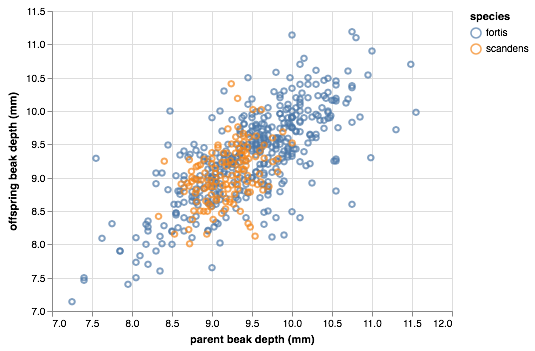

In [2]:
df = pd.read_csv('data/grant_heredity.csv')

alt.Chart(df
    ).mark_point(
    ).encode(
        x=alt.X('parent beak depth (mm):Q', scale=alt.Scale(zero=False)),
        y=alt.Y('offspring beak depth (mm):Q', scale=alt.Scale(zero=False)),
        color='species'
    )

At first glance, it appears as though the *G. fortis* birds show higher heritatiblity of beak depth. Let's to the calculation.

In [3]:
# Extract data as numpy arrays
inds = df['species']=='scandens'
bd_parent_scandens = df.loc[inds, 'parent beak depth (mm)'].values
bd_offspring_scandens = df.loc[inds, 'offspring beak depth (mm)'].values

inds = df['species']=='fortis'
bd_parent_fortis = df.loc[inds, 'parent beak depth (mm)'].values
bd_offspring_fortis = df.loc[inds, 'offspring beak depth (mm)'].values

def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for single statistic."""
    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens,
                                     bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis,
                                   bd_offspring_fortis)

# Acquire 10000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=10000)
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=10000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

print('scandens confidence interval:', conf_int_scandens)
print('  fortis confidence interval:', conf_int_fortis)

scandens confidence interval: [0.34597421 0.7536939 ]
  fortis confidence interval: [0.6461735  0.79680839]


Indeed, *G. fortis* does seem to have higher heritability, but the large uncertainty in the *G. scandens* result means that we can't be certain. Their confidence intervals overlap. If we just reported the value calculated directly from the data, we would get the following.

In [4]:
print('scandens:', heritability_scandens)
print('fortis:', heritability_fortis)

scandens: 0.5485340868685982
fortis: 0.722905191143816


This might look like a big difference, but the confidence intervals tell us that it is not. Here we can see more of the power of the bootstrap. We can also get a confidence interval on the *difference* in heritability. To do that, we simply subtract the two sets of bootstrap replicates.

In [5]:
conf_int_diff = np.percentile(replicates_fortis - replicates_scandens,
                              [2.5, 97.5])
print('fortis - scandens:', conf_int_diff)

fortis - scandens: [-0.04345204  0.39110291]


This tells us that there is most likely a difference between the two, but we cannot say for certain.

<br />

## Practice 2: Plotting with Bokeh

The `bootcamp_utils` module has several convenient functions for making plots with Bokeh. To make sure you have the updated version installed, you should

    git pull upstream master
    
You should then `cd` into the `~/git/bootcamp/modules` directory and do

    pip install -e bootcamp_utils
    
You should then restart the kernel of your Jupyter notebook.

To find out what is available, you can try tab completion after typing `bootcamp_utils.bokeh_`. Then, read the doc strings of the plotting functions, and play around with them. You can use any of the data sets we've used in the bootcamp, but the Darwin finch data set or the frog data set will probably be best.

### Practice 2: *solution*

I'll go through the plot types sequentially with the Darwin finch set.

In [6]:
df = pd.read_csv('data/grant_complete.csv', comment='#')

df.head()

,band,beak depth (mm),beak length (mm),species,year
0,20123,8.05,9.25,fortis,1973
1,20126,10.45,11.35,fortis,1973
2,20128,9.55,10.15,fortis,1973
3,20129,8.75,9.95,fortis,1973
4,20133,10.15,11.55,fortis,1973


#### Box plots

The `cats` kwarg say which variables are categorical. You can choose more than one column of the `DataFrame`, and the ticks will be labeled accordingly.

In [7]:
p = bootcamp_utils.bokeh_box(df, 
                             cats=['species', 'year'], 
                             val='beak depth (mm)')

# Rotate tick labels
p.xaxis.major_label_orientation = np.pi/4

bokeh.io.show(p)

#### Jitter plots

Jitter plots have the same pretty much the same call signature as box plots.

In [8]:
p = bootcamp_utils.bokeh_jitter(df, 
                                cats=['species', 'year'], 
                                val='beak depth (mm)',
                                alpha=0.1)

# Rotate tick labels
p.xaxis.major_label_orientation = np.pi/4

bokeh.io.show(p)

If we want, we can overlay box plots and jitter plots using the `p` kwarg.  All of the `bootcamp_utils.bokeh_*` functions have a `p` kwarg, which enables overlays by populating the figure stored in `p` with the new glyphs.

In [9]:
p = bootcamp_utils.bokeh_box(df,
                             cats=['species', 'year'], 
                             val='beak depth (mm)',
                             fill_alpha=0)

p = bootcamp_utils.bokeh_jitter(df, 
                                cats=['species', 'year'], 
                                val='beak depth (mm)',
                                alpha=0.1,
                                p=p)

# Rotate tick labels
p.xaxis.major_label_orientation = np.pi/4

bokeh.io.show(p)

#### ECDF

The `bootcamp_utils.bokeh_ecdf()` function takes a single array as input and makes an ECDF with it. With the `formal=True` kwarg, it makes a formal, staircase ECDF.

In [10]:
data = df.loc[(df['year']==1987) & (df['species']=='scandens'), 'beak depth (mm)']
p = bootcamp_utils.bokeh_ecdf(data, x_axis_label='beak depth (mm)', formal=True)

bokeh.io.show(p)

#### Colored ECDF

This is a single ECDF, but the dots are colored according to the `cats` kwarg. For this plot, we will just use the data from 1987.

In [11]:
p = bootcamp_utils.bokeh_colored_ecdf(df.loc[df['year']==1987, :], 
                                      cats='species', 
                                      val='beak depth (mm)')

bokeh.io.show(p)

#### ECDF collection

This works just like `colored_ecdf()`, but with separate ECDFs plotted for each category.

In [12]:
p = bootcamp_utils.bokeh_ecdf_collection(df.loc[df['year']==1987, :], 
                                         cats='species', 
                                         val='beak depth (mm)')

bokeh.io.show(p)

#### Histograms

The function `bootcamp_utils.bokeh_histogram()` generates a histogram, plotted as steps. If you want to add multiple histograms to a plot, we can pass the `p` kwarg to say on which plot to populate the histogram.

In [13]:
data = df.loc[(df['year']==1987) & (df['species']=='fortis'), 'beak depth (mm)']
p = bootcamp_utils.bokeh_histogram(data,
                                   bins=int(np.sqrt(len(data))),
                                   x_axis_label='beak depth (mm)',
                                   legend='fortis',
                                   fill_alpha=0.5,
                                   density=True,
                                   kind='step_filled')

data = df.loc[(df['year']==1987) & (df['species']=='scandens'), 'beak depth (mm)']
p = bootcamp_utils.bokeh_histogram(data,
                                   bins=int(np.sqrt(len(data))),
                                   p=p, 
                                   line_color='orange',
                                   fill_color='orange',
                                   fill_alpha=0.5,
                                   legend='scandens',
                                   density=True,
                                   kind='step_filled')

bokeh.io.show(p)

#### Fill between

When plotting confidence intervals, from pairs bootstraps of linear regressions, we needed to fill the area between two curves representing the top and bottom of at 95% confidence interval. The function `bootcamp_utils.bokeh_fill_between()` does this. First, let's get some pairs bootstrap replicates, as we did in [lesson 35](../lessons/l35_pairs_bootstrap.html).

In [14]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Take samples
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

# Get beak lengths and depths as Numpy arrays
beak_length = df.loc[df['species']=='scandens', 'beak length (mm)'].values
beak_depth = df.loc[df['species']=='scandens', 'beak depth (mm)'].values

# Draw replicates
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(beak_length,
                                                        beak_depth,
                                                        size=10000)

# x-values
x = np.linspace(10.5, 16.5, 200)

# y-values of each point
y = np.outer(bs_slope_reps, x) + np.stack([bs_intercept_reps]*200, axis=1)

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [2.5, 97.5], axis=0)

Now we can generate the scatter plot with bootstrap confidence interval.

In [15]:
p = bootcamp_utils.bokeh_fill_between(x, high, x, low, 
                                      x_axis_label='beak length (mm)',
                                      y_axis_label='beak depth (mm)',
                                      fill_color='orange',
                                      line_color='orange',
                                      fill_alpha=0.5)
p.circle(x=beak_length, y=beak_depth, alpha=0.3)

bokeh.io.show(p)